# PHƯƠNG ÁN B: XÂY DỰNG LẠI BÀI TOÁN VỚI 4 BIẾN ĐỘC LẬP + POLYNOMIAL

**Mục tiêu:** Dự đoán `tải tiêu thụ` CHỈ từ 4 biến thực sự độc lập (không dùng biến phái sinh)

**Features gốc (4):** độ ẩm, nhiệt độ, góc nghiêng, ca

**Kỹ thuật:** Polynomial Features (degree 2) → tạo thêm biến tương tác & phi tuyến

**Thách thức:**
- `công suất tb` và `sản lượng` ĐỀU bị loại (vì chúng là biến phái sinh trực tiếp từ target)
- Các biến còn lại có tương quan RẤT THẤP với target (< 0.005), ngoại trừ `ca` (-0.964)
- Đây là bài toán dự đoán THỰC TẾ hơn (không "gian lận")

**Pipeline:**
1. EDA & Giải thích lý do
2. Polynomial Feature Engineering
3. Train & Evaluate 19+ mô hình
4. Hyperparameter Tuning
5. Stacking Ensemble
6. Xuất kết quả

## 0. CÀI ĐẶT THƯ VIỆN

In [1]:
!pip install numpy pandas scikit-learn openpyxl matplotlib seaborn xgboost lightgbm -q

## 1. IMPORT & CẤU HÌNH

In [2]:
import os, time, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import clone
from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
)
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 10

RANDOM_STATE = 42
N_FOLDS = 5
TEST_SIZE = 0.2
np.random.seed(RANDOM_STATE)

print("Libraries loaded OK!")

Libraries loaded OK!


## 2. ĐỌC DỮ LIỆU & EDA

In [4]:
df = pd.read_excel('data3.xlsx')
cols = list(df.columns)
print(f"Shape: {df.shape}")
print(f"Columns: {cols}")
df.head()

Shape: (5220, 7)
Columns: ['độ ẩm', 'nhiệt độ', 'góc nghiêng', 'ca', 'công suất tb', 'sản lượng', 'tải tiêu thụ']


,độ ẩm,nhiệt độ,góc nghiêng,ca,công suất tb,sản lượng,tải tiêu thụ
0,97,29,20,1,302.0,2416.0,12080
1,95,28,20,1,290.0,2320.0,11600
2,92,27,20,1,293.0,2344.0,11720
3,92,27,20,1,286.0,2288.0,11440
4,90,27,20,1,289.0,2312.0,11560


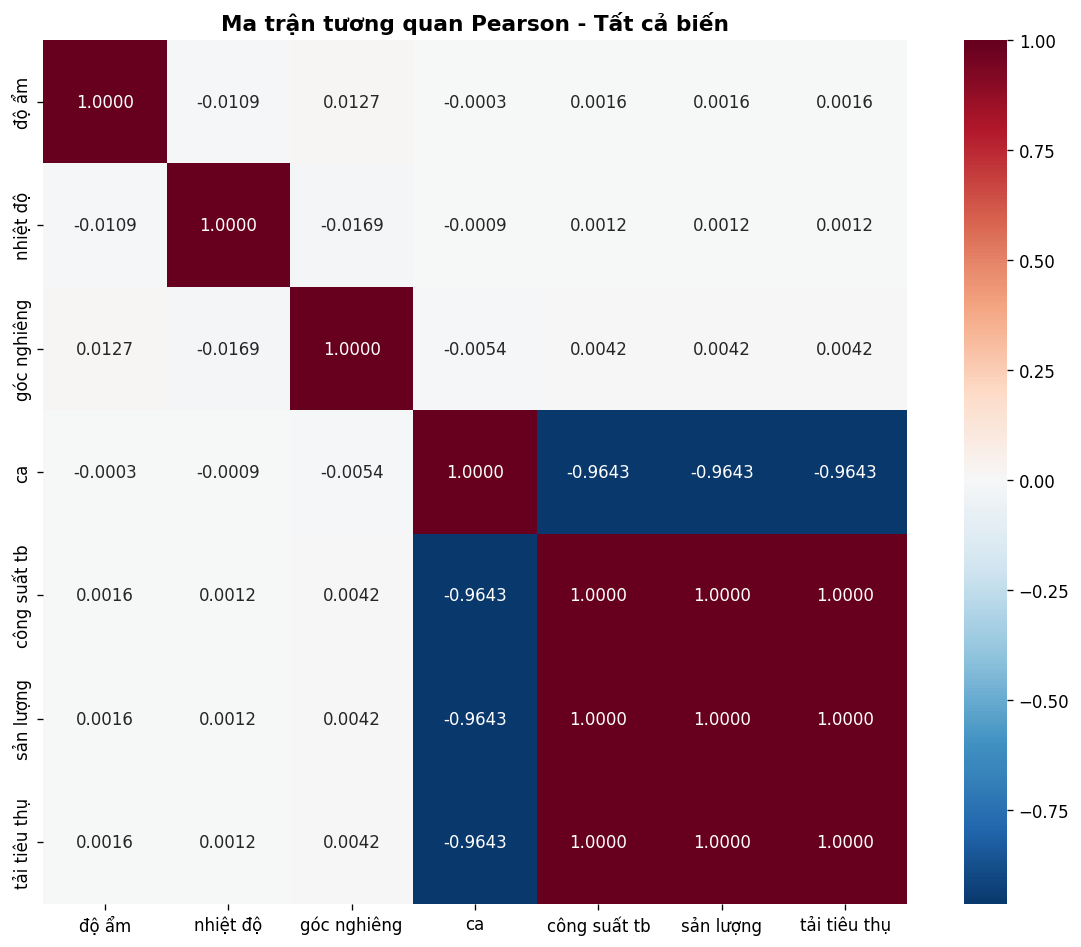


Tương quan với 'tải tiêu thụ':
  độ ẩm               :   0.0016
  nhiệt độ            :   0.0012
  góc nghiêng         :   0.0042
  ca                  :  -0.9643
  công suất tb        :   1.0000
  sản lượng           :   1.0000


In [5]:
# Ma trận tương quan đầy đủ
corr = df.corr()
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt='.4f', cmap='RdBu_r', center=0, square=True, ax=ax)
ax.set_title('Ma trận tương quan Pearson - Tất cả biến', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('01_correlation_full.png', dpi=150, bbox_inches='tight')
plt.show()

target_col = cols[-1]
print(f"\nTương quan với '{target_col}':")
for feat in cols[:-1]:
    print(f"  {feat:<20}: {corr.loc[feat, target_col]:>8.4f}")

In [6]:
# GIẢI THÍCH: Tại sao chỉ dùng 4 biến?
print("=" * 60)
print("LÝ DO LOẠI BỎ 'công suất tb' VÀ 'sản lượng':")
print("=" * 60)
print(f"\n  sản lượng    = công suất tb × {(df[cols[5]] / df[cols[4]]).unique()[0]:.0f}  (chính xác 100%)")
print(f"  tải tiêu thụ ≈ công suất tb × {(df[cols[6]] / df[cols[4]]).mean():.1f}  (gần chính xác)")
print(f"\n  → 3 biến này là CÙNG MỘT BIẾN, chỉ khác hệ số tỷ lệ")
print(f"  → Dùng 'công suất tb' để dự đoán 'tải tiêu thụ' = chỉ cần học phép nhân")
print(f"  → Mô hình sẽ KHÔNG có giá trị dự đoán thực tế")
print(f"\n  ⇒ PHƯƠNG ÁN B: Chỉ dùng 4 biến ĐỘC LẬP THỰC SỰ")
print(f"     1. Độ ẩm       (corr = {corr.loc[cols[0], target_col]:.4f})")
print(f"     2. Nhiệt độ    (corr = {corr.loc[cols[1], target_col]:.4f})")
print(f"     3. Góc nghiêng (corr = {corr.loc[cols[2], target_col]:.4f})")
print(f"     4. Ca          (corr = {corr.loc[cols[3], target_col]:.4f})")

LÝ DO LOẠI BỎ 'công suất tb' VÀ 'sản lượng':

  sản lượng    = công suất tb × 8  (chính xác 100%)
  tải tiêu thụ ≈ công suất tb × 40.0  (gần chính xác)

  → 3 biến này là CÙNG MỘT BIẾN, chỉ khác hệ số tỷ lệ
  → Dùng 'công suất tb' để dự đoán 'tải tiêu thụ' = chỉ cần học phép nhân
  → Mô hình sẽ KHÔNG có giá trị dự đoán thực tế

  ⇒ PHƯƠNG ÁN B: Chỉ dùng 4 biến ĐỘC LẬP THỰC SỰ
     1. Độ ẩm       (corr = 0.0016)
     2. Nhiệt độ    (corr = 0.0012)
     3. Góc nghiêng (corr = 0.0042)
     4. Ca          (corr = -0.9643)


## 3. CHUẨN BỊ DỮ LIỆU - 4 BIẾN + POLYNOMIAL

In [7]:
target_col = cols[-1]
features_B = [cols[0], cols[1], cols[2], cols[3]]
y = df[target_col].values
X_base = df[features_B].values

print(f"Features gốc ({len(features_B)}): {features_B}")
print(f"Target: {target_col}")
print(f"\nTạo Polynomial Features (degree=2)...")

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
X = poly.fit_transform(X_base)
poly_names = list(poly.get_feature_names_out(features_B))

print(f"Features sau polynomial: {X.shape[1]}")
print(f"Tên features:")
for i, name in enumerate(poly_names):
    print(f"  {i+1:2d}. {name}")

print(f"\nX shape: {X.shape}")
print(f"y range: [{y.min():.0f}, {y.max():.0f}], mean={y.mean():.2f}, std={y.std():.2f}")

Features gốc (4): ['độ ẩm', 'nhiệt độ', 'góc nghiêng', 'ca']
Target: tải tiêu thụ

Tạo Polynomial Features (degree=2)...
Features sau polynomial: 14
Tên features:
   1. độ ẩm
   2. nhiệt độ
   3. góc nghiêng
   4. ca
   5. độ ẩm^2
   6. độ ẩm nhiệt độ
   7. độ ẩm góc nghiêng
   8. độ ẩm ca
   9. nhiệt độ^2
  10. nhiệt độ góc nghiêng
  11. nhiệt độ ca
  12. góc nghiêng^2
  13. góc nghiêng ca
  14. ca^2

X shape: (5220, 14)
y range: [8960, 12400], mean=10616.94, std=1223.90


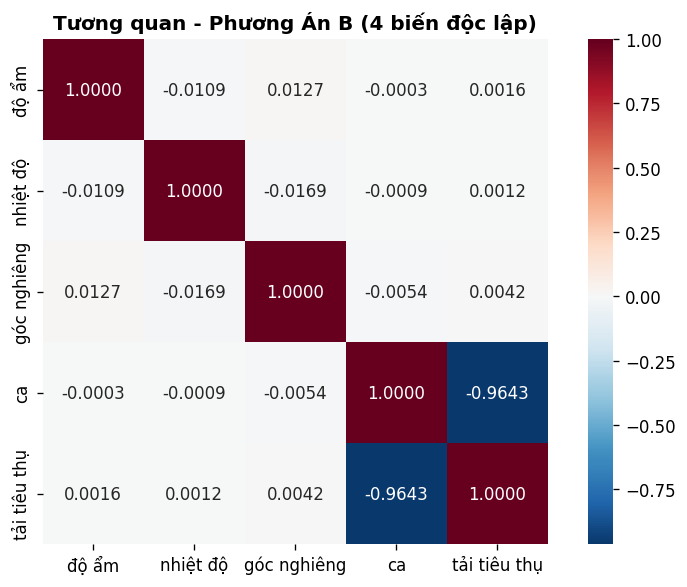

In [8]:
# Heatmap tương quan 4 biến gốc + target
df_B = df[features_B + [target_col]]
corr_B = df_B.corr()

fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(corr_B, annot=True, fmt='.4f', cmap='RdBu_r', center=0, square=True, ax=ax)
ax.set_title('Tương quan - Phương Án B (4 biến độc lập)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('02_correlation_planB.png', dpi=150, bbox_inches='tight')
plt.show()

In [9]:
# Train/Test Split + StandardScaler
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)
X_all_sc = scaler.transform(X)

print(f"Train: {X_train_sc.shape[0]} samples, {X_train_sc.shape[1]} features")
print(f"Test:  {X_test_sc.shape[0]} samples")
print(f"StandardScaler applied ✓")

Train: 4176 samples, 14 features
Test:  1044 samples
StandardScaler applied ✓


## 4. HÀM TIỆN ÍCH

In [10]:
def calc_metrics(y_true, y_pred):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    nrmse = rmse / (y_true.max() - y_true.min()) if (y_true.max() - y_true.min()) > 0 else 0
    return {'MAE': round(mae, 4), 'MSE': round(mse, 4), 'RMSE': round(rmse, 4),
            'MAPE (%)': round(mape, 6), 'nRMSE': round(nrmse, 6), 'R2': round(r2, 6)}

def run_kfold(model, X, y, n_folds=N_FOLDS):
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_STATE)
    fold_metrics = []
    for train_idx, val_idx in kfold.split(X):
        m = clone(model)
        m.fit(X[train_idx], y[train_idx])
        fold_metrics.append(calc_metrics(y[val_idx], m.predict(X[val_idx])))
    result = {}
    for key in fold_metrics[0]:
        values = [fm[key] for fm in fold_metrics]
        result[f'{key}_mean'] = round(np.mean(values), 6)
        result[f'{key}_std'] = round(np.std(values), 6)
    return result

print("Utility functions defined ✓")

Utility functions defined ✓


## 5. ĐỊNH NGHĨA CÁC MÔ HÌNH

In [11]:
models = {}

# ---- MLP Variants (nhiều cấu hình hơn vì bài toán khó hơn) ----
for layers, tag in [((4,), '4'), ((8,), '8'), ((16,), '16'), ((32,), '32'), ((64,), '64'),
                     ((16, 8), '16_8'), ((32, 16), '32_16'), ((64, 32), '64_32'),
                     ((32, 16, 8), '32_16_8'), ((64, 32, 16), '64_32_16')]:
    models[f'MLP_({tag})'] = MLPRegressor(
        hidden_layer_sizes=layers, activation='relu', solver='adam',
        alpha=0.001, learning_rate='adaptive',
        max_iter=2000, early_stopping=True, validation_fraction=0.1,
        n_iter_no_change=20, random_state=RANDOM_STATE)

models['MLP_tanh_(32,16)'] = MLPRegressor(
    hidden_layer_sizes=(32, 16), activation='tanh', solver='adam',
    alpha=0.0001, learning_rate='adaptive',
    max_iter=2000, early_stopping=True, validation_fraction=0.1,
    n_iter_no_change=20, random_state=RANDOM_STATE)

models['MLP_lbfgs_(32,16)'] = MLPRegressor(
    hidden_layer_sizes=(32, 16), activation='relu', solver='lbfgs',
    alpha=0.001, max_iter=500, random_state=RANDOM_STATE)

# ---- Random Forest ----
models['RF_300'] = RandomForestRegressor(
    n_estimators=300, max_depth=None, min_samples_split=5,
    min_samples_leaf=2, random_state=RANDOM_STATE, n_jobs=-1)
models['RF_500'] = RandomForestRegressor(
    n_estimators=500, max_depth=20, min_samples_split=3,
    min_samples_leaf=1, random_state=RANDOM_STATE, n_jobs=-1)

# ---- Gradient Boosting ----
models['GB_300'] = GradientBoostingRegressor(
    n_estimators=300, max_depth=5, learning_rate=0.1,
    subsample=0.8, random_state=RANDOM_STATE)
models['GB_500'] = GradientBoostingRegressor(
    n_estimators=500, max_depth=6, learning_rate=0.05,
    subsample=0.9, min_samples_split=5, random_state=RANDOM_STATE)

# ---- XGBoost ----
models['XGB_300'] = XGBRegressor(
    n_estimators=300, max_depth=6, learning_rate=0.1,
    subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1, reg_lambda=1.0,
    random_state=RANDOM_STATE, verbosity=0, n_jobs=-1)
models['XGB_tuned'] = XGBRegressor(
    n_estimators=500, max_depth=8, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.9, reg_alpha=0.01, reg_lambda=0.5,
    min_child_weight=3, random_state=RANDOM_STATE, verbosity=0, n_jobs=-1)

# ---- LightGBM ----
models['LGBM_300'] = LGBMRegressor(
    n_estimators=300, max_depth=6, learning_rate=0.1,
    subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1, reg_lambda=1.0,
    random_state=RANDOM_STATE, verbosity=-1, n_jobs=-1)
models['LGBM_tuned'] = LGBMRegressor(
    n_estimators=500, max_depth=-1, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.9, num_leaves=50,
    reg_alpha=0.01, reg_lambda=0.5,
    random_state=RANDOM_STATE, verbosity=-1, n_jobs=-1)

# ---- SVR ----
models['SVR_rbf'] = SVR(kernel='rbf', C=100, epsilon=0.1, gamma='scale')
models['SVR_poly'] = SVR(kernel='poly', C=100, epsilon=0.1, degree=3)

# ---- Linear Baseline ----
models['ElasticNet'] = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=RANDOM_STATE)
models['Ridge'] = Ridge(alpha=1.0)

print(f"Tổng cộng {len(models)} mô hình:")
for i, name in enumerate(models, 1):
    print(f"  {i:2d}. {name}")

Tổng cộng 24 mô hình:
   1. MLP_(4)
   2. MLP_(8)
   3. MLP_(16)
   4. MLP_(32)
   5. MLP_(64)
   6. MLP_(16_8)
   7. MLP_(32_16)
   8. MLP_(64_32)
   9. MLP_(32_16_8)
  10. MLP_(64_32_16)
  11. MLP_tanh_(32,16)
  12. MLP_lbfgs_(32,16)
  13. RF_300
  14. RF_500
  15. GB_300
  16. GB_500
  17. XGB_300
  18. XGB_tuned
  19. LGBM_300
  20. LGBM_tuned
  21. SVR_rbf
  22. SVR_poly
  23. ElasticNet
  24. Ridge


## 6. TRAIN & EVALUATE TẤT CẢ MÔ HÌNH

In [12]:
all_results = []
predictions = {}

total_start = time.time()
print(f"Bắt đầu train {len(models)} mô hình (4 features + poly → {X.shape[1]} features)...")
print("=" * 80)

for i, (name, model) in enumerate(models.items(), 1):
    print(f"\n[{i}/{len(models)}] {name}...", end=" ")

    t0 = time.time()
    try:
        m = clone(model)
        m.fit(X_train_sc, y_train)
        train_time = round(time.time() - t0, 3)

        y_pred_train = m.predict(X_train_sc)
        y_pred_test = m.predict(X_test_sc)
        test_metrics = calc_metrics(y_test, y_pred_test)
        train_metrics = calc_metrics(y_train, y_pred_train)
        cv = run_kfold(clone(model), X_all_sc, y)

        row = {
            'Mo hinh': name,
            'MAE (Test)': test_metrics['MAE'],
            'RMSE (Test)': test_metrics['RMSE'],
            'MAPE % (Test)': test_metrics['MAPE (%)'],
            'nRMSE (Test)': test_metrics['nRMSE'],
            'R2 (Test)': test_metrics['R2'],
            'MAE (Train)': train_metrics['MAE'],
            'MAPE % (Train)': train_metrics['MAPE (%)'],
            'MAE_CV_mean': cv['MAE_mean'], 'MAE_CV_std': cv['MAE_std'],
            'MAPE_CV_mean': cv['MAPE (%)_mean'], 'MAPE_CV_std': cv['MAPE (%)_std'],
            'R2_CV_mean': cv['R2_mean'],
            'Train Time (s)': train_time,
        }
        all_results.append(row)
        predictions[name] = {
            'y_test': y_test, 'y_pred_test': y_pred_test,
            'y_train': y_train, 'y_pred_train': y_pred_train, 'model': m,
        }

        print(f"✓ MAE={test_metrics['MAE']:.2f} | MAPE={test_metrics['MAPE (%)']:.4f}% | R²={test_metrics['R2']:.6f} ({train_time}s)")

    except Exception as e:
        print(f"✗ ERROR: {str(e)[:80]}")

elapsed = time.time() - total_start
print(f"\n{'='*80}")
print(f"Hoàn tất {len(all_results)} mô hình trong {elapsed:.1f}s ({elapsed/60:.1f} phút)")

Bắt đầu train 24 mô hình (4 features + poly → 14 features)...

[1/24] MLP_(4)... ✓ MAE=6545.08 | MAPE=65.1151% | R²=-34.447958 (12.293s)

[2/24] MLP_(8)... ✓ MAE=294.52 | MAPE=2.7624% | R²=0.922598 (12.641s)

[3/24] MLP_(16)... ✓ MAE=308.36 | MAPE=2.9024% | R²=0.911159 (8.983s)

[4/24] MLP_(32)... ✓ MAE=286.92 | MAPE=2.6981% | R²=0.927606 (9.609s)

[5/24] MLP_(64)... ✓ MAE=292.69 | MAPE=2.7509% | R²=0.924290 (11.105s)

[6/24] MLP_(16_8)... ✓ MAE=290.40 | MAPE=2.7350% | R²=0.927203 (4.591s)

[7/24] MLP_(32_16)... ✓ MAE=289.96 | MAPE=2.7262% | R²=0.926731 (5.394s)

[8/24] MLP_(64_32)... ✓ MAE=287.96 | MAPE=2.7044% | R²=0.927211 (8.234s)

[9/24] MLP_(32_16_8)... ✓ MAE=290.57 | MAPE=2.7279% | R²=0.925728 (3.185s)

[10/24] MLP_(64_32_16)... ✓ MAE=288.69 | MAPE=2.7143% | R²=0.927609 (6.024s)

[11/24] MLP_tanh_(32,16)... ✓ MAE=9987.40 | MAPE=93.7685% | R²=-65.457000 (46.744s)

[12/24] MLP_lbfgs_(32,16)... ✓ MAE=288.14 | MAPE=2.7079% | R²=0.928052 (10.929s)

[13/24] RF_300... ✓ MAE=288.37 | MA

## 7. BẢNG XẾP HẠNG (TRƯỚC TUNING)

In [13]:
df_results = pd.DataFrame(all_results).sort_values('MAE (Test)').reset_index(drop=True)
df_results.index = df_results.index + 1
df_results.index.name = 'Rank'

print("BẢNG XẾP HẠNG - PHƯƠNG ÁN B (4 features + polynomial)")
print("=" * 80)
display(df_results[['Mo hinh', 'MAE (Test)', 'RMSE (Test)', 'MAPE % (Test)',
                     'nRMSE (Test)', 'R2 (Test)', 'MAE_CV_mean', 'MAPE_CV_mean',
                     'Train Time (s)']].style.format({
    'MAE (Test)': '{:.2f}', 'RMSE (Test)': '{:.2f}',
    'MAPE % (Test)': '{:.4f}', 'nRMSE (Test)': '{:.6f}',
    'R2 (Test)': '{:.6f}', 'MAE_CV_mean': '{:.2f}',
    'MAPE_CV_mean': '{:.4f}', 'Train Time (s)': '{:.3f}',
}).background_gradient(subset=['MAE (Test)', 'MAPE % (Test)'], cmap='RdYlGn_r'))

BẢNG XẾP HẠNG - PHƯƠNG ÁN B (4 features + polynomial)


,Mo hinh,MAE (Test),RMSE (Test),MAPE % (Test),nRMSE (Test),R2 (Test),MAE_CV_mean,MAPE_CV_mean,Train Time (s)
Rank,,,,,,,,,
1,MLP_(32),286.92,332.14,2.6981,0.096553,0.927606,286.07,2.7009,9.609
2,Ridge,287.58,329.90,2.7037,0.095902,0.928580,280.90,2.6503,0.012
3,MLP_(64_32),287.96,333.05,2.7044,0.096816,0.927211,282.20,2.6638,8.234
4,"MLP_lbfgs_(32,16)",288.14,331.12,2.7079,0.096256,0.928052,281.42,2.6557,10.929
5,GB_300,288.27,335.25,2.7072,0.097457,0.926244,283.11,2.6712,1.432
6,RF_500,288.31,335.06,2.7074,0.097400,0.926331,283.03,2.6705,3.581
7,LGBM_300,288.34,335.06,2.7077,0.097401,0.926329,283.04,2.6706,0.733
8,LGBM_tuned,288.35,335.08,2.7079,0.097408,0.926318,283.05,2.6707,0.554
9,RF_300,288.37,335.13,2.7081,0.097423,0.926296,283.06,2.6708,1.694


## 8. STACKING ENSEMBLE (TOP 3)

In [14]:
top3_names = list(df_results['Mo hinh'].head(3))
top3_models = {n: models[n] for n in top3_names}

print(f"Top 3 cho Stacking:")
for i, n in enumerate(top3_names, 1):
    r = df_results[df_results['Mo hinh'] == n].iloc[0]
    print(f"  {i}. {n} (MAE={r['MAE (Test)']:.2f})")

estimators = [(n, clone(m)) for n, m in top3_models.items()]
stacking = StackingRegressor(estimators=estimators, final_estimator=Ridge(alpha=1.0), cv=3, n_jobs=-1)

print(f"\nTraining Stacking Ensemble...")
t0 = time.time()
stacking.fit(X_train_sc, y_train)
stk_time = round(time.time() - t0, 3)

y_pred_stk = stacking.predict(X_test_sc)
test_stk = calc_metrics(y_test, y_pred_stk)
train_stk = calc_metrics(y_train, stacking.predict(X_train_sc))

stacking_cv = StackingRegressor(
    estimators=[(n, clone(m)) for n, m in top3_models.items()],
    final_estimator=Ridge(alpha=1.0), cv=3, n_jobs=-1)
cv_stk = run_kfold(stacking_cv, X_all_sc, y)

stk_name = f"Stacking({'+'.join(top3_names)})"
stk_row = {
    'Mo hinh': stk_name,
    'MAE (Test)': test_stk['MAE'], 'RMSE (Test)': test_stk['RMSE'],
    'MAPE % (Test)': test_stk['MAPE (%)'], 'nRMSE (Test)': test_stk['nRMSE'],
    'R2 (Test)': test_stk['R2'],
    'MAE (Train)': train_stk['MAE'], 'MAPE % (Train)': train_stk['MAPE (%)'],
    'MAE_CV_mean': cv_stk['MAE_mean'], 'MAE_CV_std': cv_stk['MAE_std'],
    'MAPE_CV_mean': cv_stk['MAPE (%)_mean'], 'MAPE_CV_std': cv_stk['MAPE (%)_std'],
    'R2_CV_mean': cv_stk['R2_mean'], 'Train Time (s)': stk_time,
}
all_results.append(stk_row)
predictions[stk_name] = {
    'y_test': y_test, 'y_pred_test': y_pred_stk,
    'y_train': y_train, 'y_pred_train': stacking.predict(X_train_sc), 'model': stacking,
}

print(f"\n✓ {stk_name}: MAE={test_stk['MAE']:.2f} | MAPE={test_stk['MAPE (%)']:.4f}% | R²={test_stk['R2']:.6f}")

Top 3 cho Stacking:
  1. MLP_(32) (MAE=286.92)
  2. Ridge (MAE=287.58)
  3. MLP_(64_32) (MAE=287.96)

Training Stacking Ensemble...

✓ Stacking(MLP_(32)+Ridge+MLP_(64_32)): MAE=287.72 | MAPE=2.7047% | R²=0.928489


## 9. HYPERPARAMETER TUNING - XGBoost

In [15]:
print("RandomizedSearchCV cho XGBoost (100 iter)...")

param_dist_xgb = {
    'n_estimators': [100, 200, 300, 500, 700, 1000],
    'max_depth': [3, 4, 5, 6, 8, 10, 12],
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.01, 0.1, 0.5, 1.0],
    'reg_lambda': [0.5, 1.0, 1.5, 2.0, 3.0],
    'min_child_weight': [1, 3, 5, 7, 10],
}

t0 = time.time()
search_xgb = RandomizedSearchCV(
    XGBRegressor(random_state=RANDOM_STATE, verbosity=0, n_jobs=-1),
    param_dist_xgb, n_iter=100, scoring='neg_mean_absolute_error',
    cv=3, n_jobs=1, random_state=RANDOM_STATE, verbose=1)
search_xgb.fit(X_train_sc, y_train)
xgb_time = time.time() - t0

print(f"\nHoàn tất trong {xgb_time:.1f}s")
print(f"Best MAE (CV): {-search_xgb.best_score_:.4f}")
print(f"Best params: {search_xgb.best_params_}")

best_xgb = search_xgb.best_estimator_
y_pred_xopt = best_xgb.predict(X_test_sc)
test_xopt = calc_metrics(y_test, y_pred_xopt)
cv_xopt = run_kfold(clone(best_xgb), X_all_sc, y)

xopt_row = {
    'Mo hinh': 'XGB_Optimized',
    'MAE (Test)': test_xopt['MAE'], 'RMSE (Test)': test_xopt['RMSE'],
    'MAPE % (Test)': test_xopt['MAPE (%)'], 'nRMSE (Test)': test_xopt['nRMSE'],
    'R2 (Test)': test_xopt['R2'],
    'MAE (Train)': calc_metrics(y_train, best_xgb.predict(X_train_sc))['MAE'],
    'MAPE % (Train)': calc_metrics(y_train, best_xgb.predict(X_train_sc))['MAPE (%)'],
    'MAE_CV_mean': cv_xopt['MAE_mean'], 'MAE_CV_std': cv_xopt['MAE_std'],
    'MAPE_CV_mean': cv_xopt['MAPE (%)_mean'], 'MAPE_CV_std': cv_xopt['MAPE (%)_std'],
    'R2_CV_mean': cv_xopt['R2_mean'], 'Train Time (s)': round(xgb_time, 3),
}
all_results.append(xopt_row)
predictions['XGB_Optimized'] = {
    'y_test': y_test, 'y_pred_test': y_pred_xopt,
    'y_train': y_train, 'y_pred_train': best_xgb.predict(X_train_sc), 'model': best_xgb,
}
print(f"\n✓ XGB_Optimized: MAE={test_xopt['MAE']:.2f} | MAPE={test_xopt['MAPE (%)']:.4f}% | R²={test_xopt['R2']:.6f}")

RandomizedSearchCV cho XGBoost (100 iter)...
Fitting 3 folds for each of 100 candidates, totalling 300 fits

Hoàn tất trong 112.9s
Best MAE (CV): 279.6318
Best params: {'subsample': 0.6, 'reg_lambda': 1.5, 'reg_alpha': 0.01, 'n_estimators': 700, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 1.0}

✓ XGB_Optimized: MAE=287.84 | MAPE=2.7045% | R²=0.927741


## 10. HYPERPARAMETER TUNING - LightGBM

In [16]:
print("RandomizedSearchCV cho LightGBM (100 iter)...")

param_dist_lgbm = {
    'n_estimators': [100, 200, 300, 500, 700, 1000],
    'max_depth': [3, 5, 6, 8, 10, -1],
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.01, 0.1, 0.5, 1.0],
    'reg_lambda': [0.5, 1.0, 1.5, 2.0, 3.0],
    'num_leaves': [15, 31, 50, 70, 100, 150],
}

t0 = time.time()
search_lgbm = RandomizedSearchCV(
    LGBMRegressor(random_state=RANDOM_STATE, verbosity=-1, n_jobs=-1),
    param_dist_lgbm, n_iter=100, scoring='neg_mean_absolute_error',
    cv=3, n_jobs=1, random_state=RANDOM_STATE, verbose=1)
search_lgbm.fit(X_train_sc, y_train)
lgbm_time = time.time() - t0

print(f"\nHoàn tất trong {lgbm_time:.1f}s")
print(f"Best MAE (CV): {-search_lgbm.best_score_:.4f}")
print(f"Best params: {search_lgbm.best_params_}")

best_lgbm = search_lgbm.best_estimator_
y_pred_lgopt = best_lgbm.predict(X_test_sc)
test_lgopt = calc_metrics(y_test, y_pred_lgopt)
cv_lgopt = run_kfold(clone(best_lgbm), X_all_sc, y)

lgopt_row = {
    'Mo hinh': 'LGBM_Optimized',
    'MAE (Test)': test_lgopt['MAE'], 'RMSE (Test)': test_lgopt['RMSE'],
    'MAPE % (Test)': test_lgopt['MAPE (%)'], 'nRMSE (Test)': test_lgopt['nRMSE'],
    'R2 (Test)': test_lgopt['R2'],
    'MAE (Train)': calc_metrics(y_train, best_lgbm.predict(X_train_sc))['MAE'],
    'MAPE % (Train)': calc_metrics(y_train, best_lgbm.predict(X_train_sc))['MAPE (%)'],
    'MAE_CV_mean': cv_lgopt['MAE_mean'], 'MAE_CV_std': cv_lgopt['MAE_std'],
    'MAPE_CV_mean': cv_lgopt['MAPE (%)_mean'], 'MAPE_CV_std': cv_lgopt['MAPE (%)_std'],
    'R2_CV_mean': cv_lgopt['R2_mean'], 'Train Time (s)': round(lgbm_time, 3),
}
all_results.append(lgopt_row)
predictions['LGBM_Optimized'] = {
    'y_test': y_test, 'y_pred_test': y_pred_lgopt,
    'y_train': y_train, 'y_pred_train': best_lgbm.predict(X_train_sc), 'model': best_lgbm,
}
print(f"\n✓ LGBM_Optimized: MAE={test_lgopt['MAE']:.2f} | MAPE={test_lgopt['MAPE (%)']:.4f}% | R²={test_lgopt['R2']:.6f}")

RandomizedSearchCV cho LightGBM (100 iter)...
Fitting 3 folds for each of 100 candidates, totalling 300 fits

Hoàn tất trong 96.9s
Best MAE (CV): 279.5389
Best params: {'subsample': 0.9, 'reg_lambda': 1.5, 'reg_alpha': 0.01, 'num_leaves': 100, 'n_estimators': 700, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.8}

✓ LGBM_Optimized: MAE=287.87 | MAPE=2.7057% | R²=0.927971


## 11. BẢNG XẾP HẠNG CUỐI CÙNG

In [17]:
df_final = pd.DataFrame(all_results).sort_values('MAE (Test)').reset_index(drop=True)
df_final.index = df_final.index + 1
df_final.index.name = 'Rank'

print("═" * 80)
print("  BẢNG XẾP HẠNG CUỐI CÙNG - PHƯƠNG ÁN B (4 biến + polynomial)")
print("═" * 80)

display(df_final[['Mo hinh', 'MAE (Test)', 'RMSE (Test)', 'MAPE % (Test)',
                   'nRMSE (Test)', 'R2 (Test)', 'MAE_CV_mean', 'MAPE_CV_mean',
                   'Train Time (s)']].style.format({
    'MAE (Test)': '{:.2f}', 'RMSE (Test)': '{:.2f}',
    'MAPE % (Test)': '{:.4f}', 'nRMSE (Test)': '{:.6f}',
    'R2 (Test)': '{:.6f}', 'MAE_CV_mean': '{:.2f}',
    'MAPE_CV_mean': '{:.4f}', 'Train Time (s)': '{:.3f}',
}).background_gradient(subset=['MAE (Test)', 'MAPE % (Test)'], cmap='RdYlGn_r')
 .background_gradient(subset=['R2 (Test)'], cmap='RdYlGn'))

════════════════════════════════════════════════════════════════════════════════
  BẢNG XẾP HẠNG CUỐI CÙNG - PHƯƠNG ÁN B (4 biến + polynomial)
════════════════════════════════════════════════════════════════════════════════


,Mo hinh,MAE (Test),RMSE (Test),MAPE % (Test),nRMSE (Test),R2 (Test),MAE_CV_mean,MAPE_CV_mean,Train Time (s)
Rank,,,,,,,,,
1,MLP_(32),286.92,332.14,2.6981,0.096553,0.927606,286.07,2.7009,9.609
2,Ridge,287.58,329.90,2.7037,0.095902,0.928580,280.90,2.6503,0.012
3,Stacking(MLP_(32)+Ridge+MLP_(64_32)),287.72,330.11,2.7047,0.095963,0.928489,281.97,2.6579,59.568
4,XGB_Optimized,287.84,331.83,2.7045,0.096463,0.927741,281.50,2.6558,112.927
5,LGBM_Optimized,287.87,331.30,2.7057,0.096309,0.927971,281.54,2.6563,96.877
6,MLP_(64_32),287.96,333.05,2.7044,0.096816,0.927211,282.20,2.6638,8.234
7,"MLP_lbfgs_(32,16)",288.14,331.12,2.7079,0.096256,0.928052,281.42,2.6557,10.929
8,GB_300,288.27,335.25,2.7072,0.097457,0.926244,283.11,2.6712,1.432
9,RF_500,288.31,335.06,2.7074,0.097400,0.926331,283.03,2.6705,3.581


In [18]:
winner = df_final.iloc[0]
print("\n" + "★" * 60)
print(f"  MÔ HÌNH CHIẾN THẮNG - PHƯƠNG ÁN B: {winner['Mo hinh']}")
print("★" * 60)
print(f"  MAE  (Test) = {winner['MAE (Test)']:.4f}")
print(f"  RMSE (Test) = {winner['RMSE (Test)']:.4f}")
print(f"  MAPE (Test) = {winner['MAPE % (Test)']:.4f}%")
print(f"  nRMSE       = {winner['nRMSE (Test)']:.6f}")
print(f"  R² (Test)   = {winner['R2 (Test)']:.6f}")
print(f"  MAE  (CV)   = {winner['MAE_CV_mean']:.4f} ± {winner['MAE_CV_std']:.4f}")
print(f"  MAPE (CV)   = {winner['MAPE_CV_mean']:.4f}% ± {winner['MAPE_CV_std']:.4f}")
print("★" * 60)
print(f"\n  ⚠️  Lưu ý: MAPE cao hơn Plan A là BÌNH THƯỜNG")
print(f"     vì Plan B chỉ dùng 4 biến thực sự ĐỘC LẬP (không dùng biến phái sinh)")
print(f"     → Kết quả có Ý NGHĨA DỰ ĐOÁN THỰC TẾ hơn!")


★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★
  MÔ HÌNH CHIẾN THẮNG - PHƯƠNG ÁN B: MLP_(32)
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★
  MAE  (Test) = 286.9218
  RMSE (Test) = 332.1440
  MAPE (Test) = 2.6981%
  nRMSE       = 0.096553
  R² (Test)   = 0.927606
  MAE  (CV)   = 286.0737 ± 5.3911
  MAPE (CV)   = 2.7009% ± 0.0475
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★

  ⚠️  Lưu ý: MAPE cao hơn Plan A là BÌNH THƯỜNG
     vì Plan B chỉ dùng 4 biến thực sự ĐỘC LẬP (không dùng biến phái sinh)
     → Kết quả có Ý NGHĨA DỰ ĐOÁN THỰC TẾ hơn!


## 12. BIỂU ĐỒ KẾT QUẢ

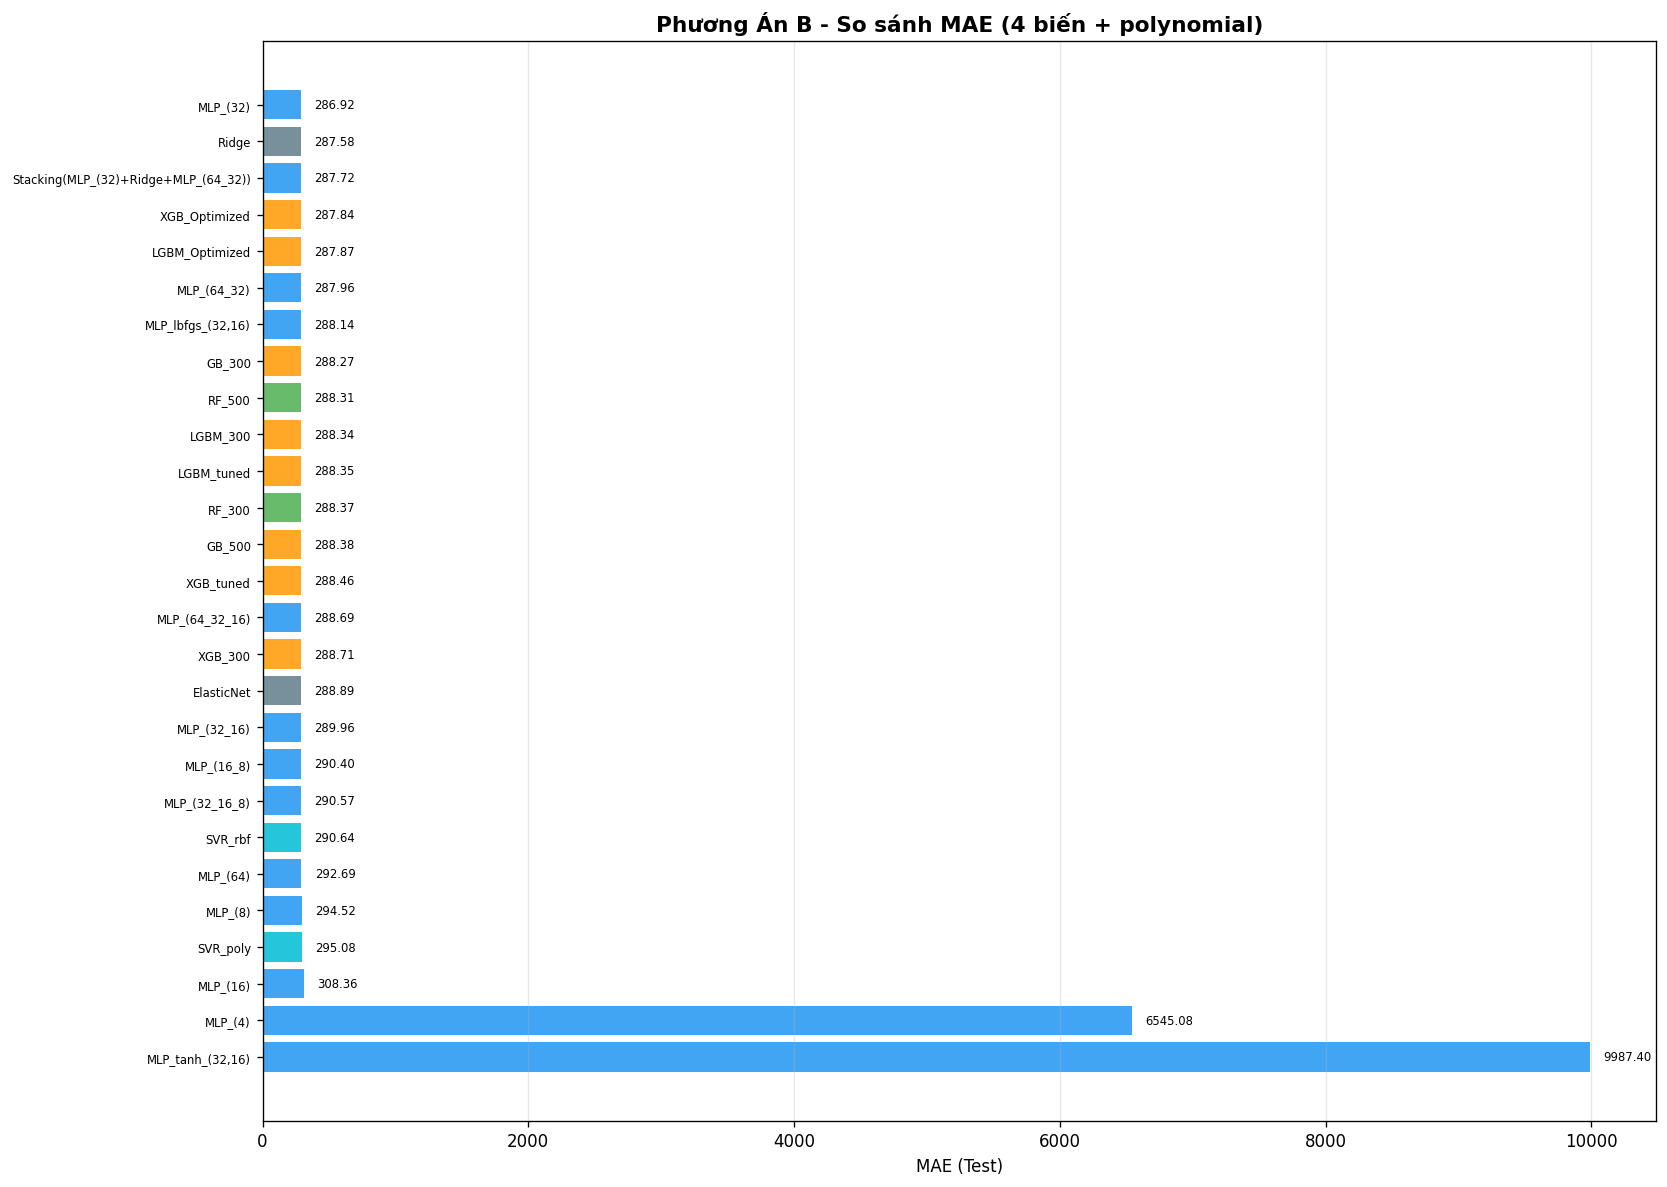

In [19]:
# Chart 1: So sánh MAE tất cả mô hình
fig, ax = plt.subplots(figsize=(14, 10))
df_plot = df_final.sort_values('MAE (Test)')
colors = ['#2196F3' if 'MLP' in n else '#4CAF50' if 'RF' in n else '#FF9800' if 'GB' in n
          else '#E91E63' if 'XGB' in n else '#9C27B0' if 'LGBM' in n
          else '#00BCD4' if 'SVR' in n else '#607D8B' if 'Elastic' in n or 'Ridge' in n
          else '#795548' for n in df_plot['Mo hinh']]

ax.barh(range(len(df_plot)), df_plot['MAE (Test)'], color=colors, alpha=0.85)
ax.set_yticks(range(len(df_plot)))
ax.set_yticklabels(df_plot['Mo hinh'], fontsize=7)
ax.set_xlabel('MAE (Test)')
ax.set_title('Phương Án B - So sánh MAE (4 biến + polynomial)', fontsize=13, fontweight='bold')
ax.invert_yaxis()
for i, v in enumerate(df_plot['MAE (Test)']):
    ax.text(v + max(df_plot['MAE (Test)'])*0.01, i, f'{v:.2f}', va='center', fontsize=7)
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('03_mae_comparison_all.png', dpi=150, bbox_inches='tight')
plt.show()

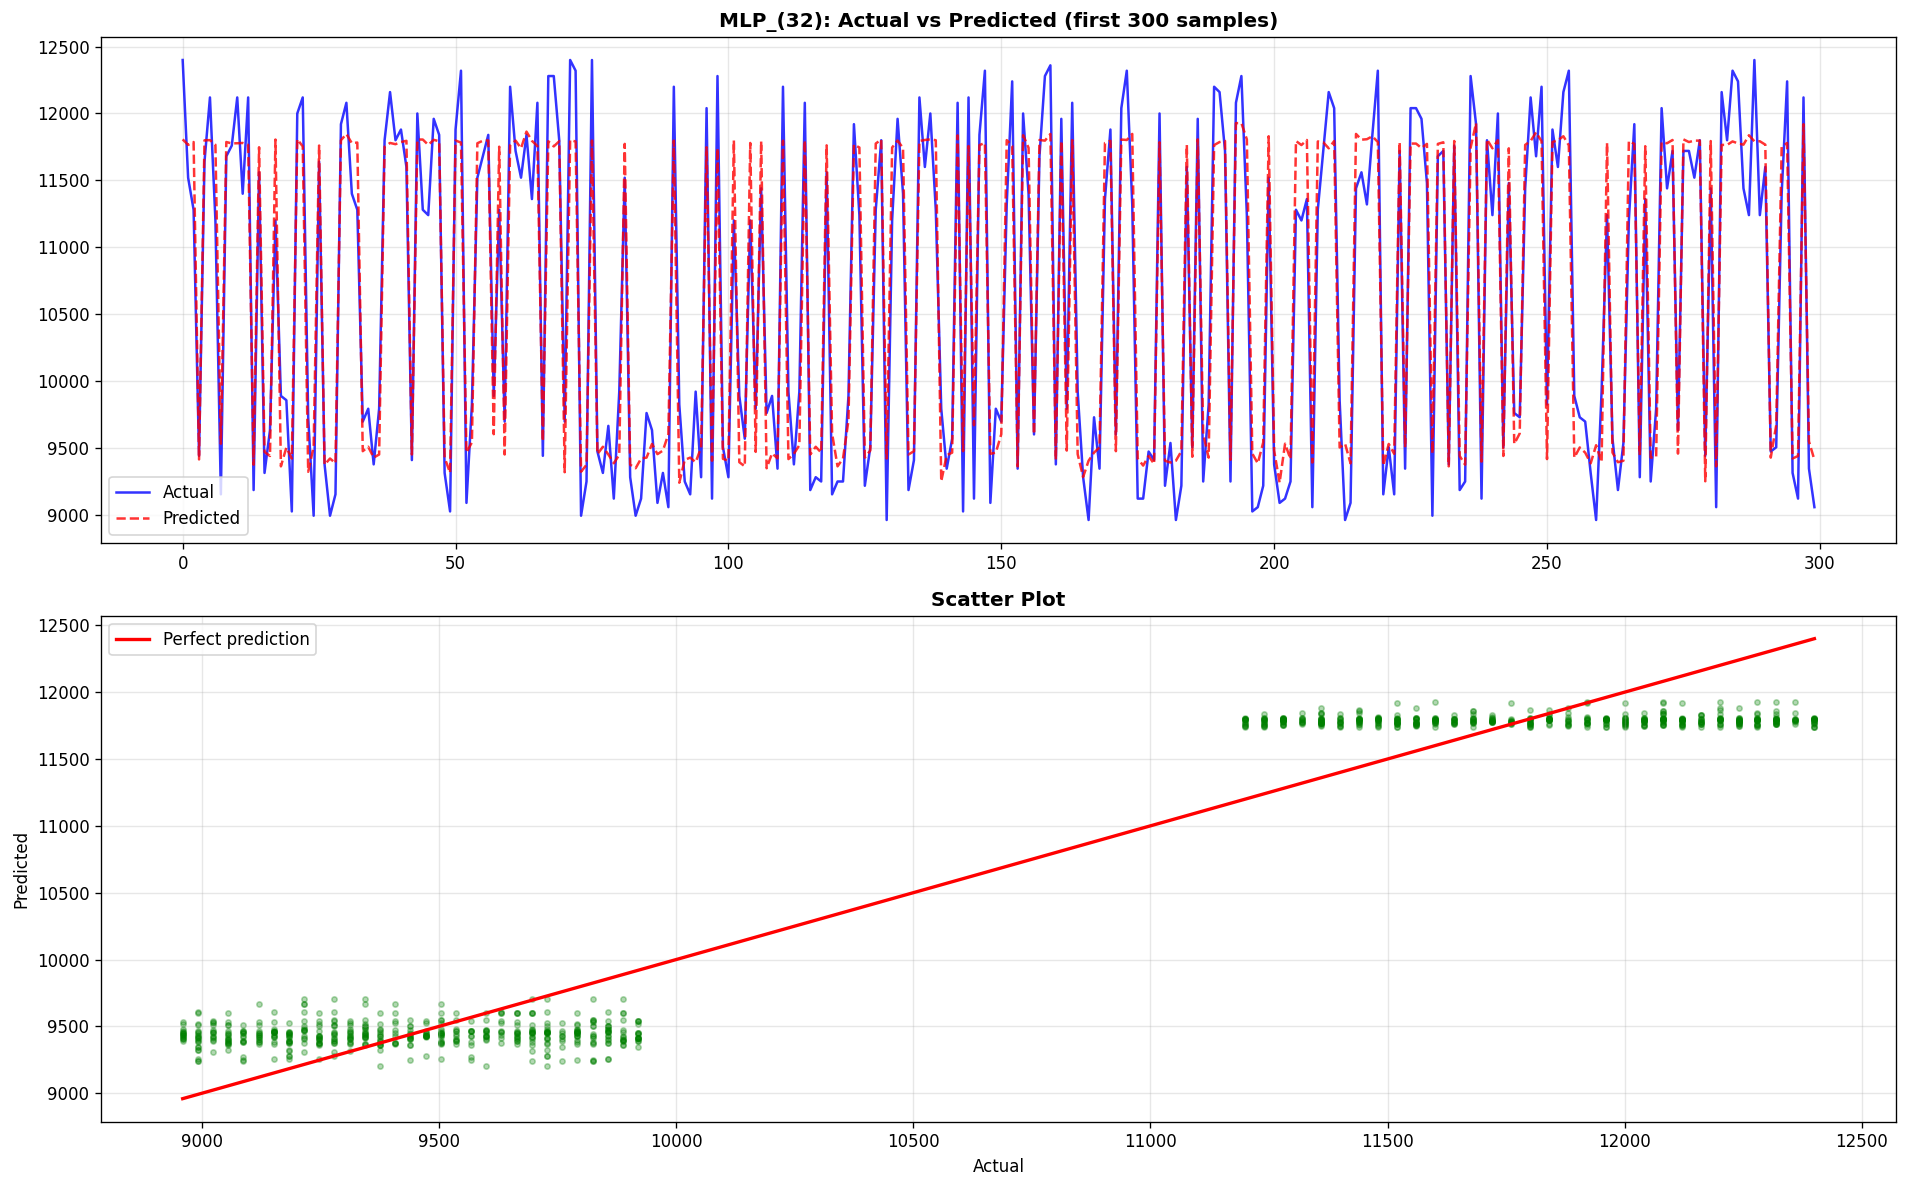

In [20]:
# Chart 2: Actual vs Predicted - Best model
best_name = winner['Mo hinh']
p = predictions[best_name]

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

n_show = min(300, len(p['y_test']))
axes[0].plot(range(n_show), p['y_test'][:n_show], 'b-', label='Actual', alpha=0.8)
axes[0].plot(range(n_show), p['y_pred_test'][:n_show], 'r--', label='Predicted', alpha=0.8)
axes[0].set_title(f'{best_name}: Actual vs Predicted (first {n_show} samples)', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].scatter(p['y_test'], p['y_pred_test'], alpha=0.3, s=10, c='green')
mn, mx = min(p['y_test'].min(), p['y_pred_test'].min()), max(p['y_test'].max(), p['y_pred_test'].max())
axes[1].plot([mn, mx], [mn, mx], 'r-', linewidth=2, label='Perfect prediction')
axes[1].set_xlabel('Actual'); axes[1].set_ylabel('Predicted')
axes[1].set_title('Scatter Plot', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('04_best_actual_vs_predicted.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Chart 3: Residual + APE Distribution
residuals = p['y_test'] - p['y_pred_test']
ape = np.abs(residuals) / p['y_test'] * 100

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(residuals, bins=50, color='#4CAF50', alpha=0.7, edgecolor='black', linewidth=0.5)
axes[0].axvline(x=0, color='red', linestyle='--')
axes[0].set_title(f'{best_name} - Residual Distribution', fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].hist(ape, bins=50, color='#FF9800', alpha=0.7, edgecolor='black', linewidth=0.5)
axes[1].set_title(f'{best_name} - APE Distribution', fontweight='bold')
axes[1].set_xlabel('APE (%)')
axes[1].grid(True, alpha=0.3)

axes[2].scatter(range(len(ape)), ape, alpha=0.3, s=5, c='#E91E63')
axes[2].axhline(y=ape.mean(), color='blue', linestyle='--', label=f'Mean={ape.mean():.2f}%')
axes[2].set_title(f'{best_name} - APE by Sample', fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('05_residual_ape.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Residual: mean={residuals.mean():.2f}, std={residuals.std():.2f}")
print(f"APE: mean={ape.mean():.2f}%, P50={np.percentile(ape,50):.2f}%, P90={np.percentile(ape,90):.2f}%, max={ape.max():.2f}%")

## 13. XUẤT KẾT QUẢ RA EXCEL

In [21]:
output_path = 'ket_qua_phuong_an_B.xlsx'

with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
    df_final.to_excel(writer, sheet_name='Xep hang tong hop')

    p = predictions[best_name]
    df_pred = pd.DataFrame({
        'Thuc te': p['y_test'],
        'Du doan': np.round(p['y_pred_test'], 2),
        'Sai so tuyet doi': np.round(np.abs(p['y_test'] - p['y_pred_test']), 2),
        'Sai so %': np.round(np.abs(p['y_test'] - p['y_pred_test']) / p['y_test'] * 100, 4),
    })
    df_pred.to_excel(writer, sheet_name='Du doan - Best Model', index=False)

    metrics_best = calc_metrics(p['y_test'], p['y_pred_test'])
    df_m = pd.DataFrame([{'Chi so': k, 'Gia tri': v} for k, v in metrics_best.items()])
    df_m.to_excel(writer, sheet_name='Chi so sai so', index=False)

    hp_data = []
    if 'search_xgb' in dir():
        hp_data.append({'Model': 'XGB_Optimized', 'Best_MAE_CV': round(-search_xgb.best_score_, 4),
                       'Best_Params': str(search_xgb.best_params_)})
    if 'search_lgbm' in dir():
        hp_data.append({'Model': 'LGBM_Optimized', 'Best_MAE_CV': round(-search_lgbm.best_score_, 4),
                       'Best_Params': str(search_lgbm.best_params_)})
    if hp_data:
        pd.DataFrame(hp_data).to_excel(writer, sheet_name='Hyperparameter Tuning', index=False)

print(f"✓ Đã xuất: {output_path}")

✓ Đã xuất: ket_qua_phuong_an_B.xlsx


## 14. TÓM TẮT & KẾT LUẬN

In [22]:
print("═" * 60)
print("  KẾT LUẬN - PHƯƠNG ÁN B (4 BIẾN ĐỘC LẬP + POLYNOMIAL)")
print("═" * 60)
print(f"\n  Features gốc: {features_B}")
print(f"  + Polynomial degree 2 → {X.shape[1]} features")
print(f"  Samples: {len(y)} (Train: {len(y_train)}, Test: {len(y_test)})")
print(f"  Tổng mô hình: {len(df_final)}")
print(f"\n  TOP 5:")
print(f"  {'-'*56}")
for i, (_, r) in enumerate(df_final.head(5).iterrows()):
    print(f"  #{i+1} {r['Mo hinh']:<30} MAE={r['MAE (Test)']:.2f} | MAPE={r['MAPE % (Test)']:.4f}%")

print(f"\n  ★ CHIẾN THẮNG: {winner['Mo hinh']}")
print(f"    MAE={winner['MAE (Test)']:.4f} | MAPE={winner['MAPE % (Test)']:.4f}% | R²={winner['R2 (Test)']:.6f}")
print(f"\n  Ý NGHĨA: Đây là kết quả dự đoán THỰC TẾ, không dùng biến phái sinh.")
print(f"  File: {output_path}")
print("═" * 60)

════════════════════════════════════════════════════════════
  KẾT LUẬN - PHƯƠNG ÁN B (4 BIẾN ĐỘC LẬP + POLYNOMIAL)
════════════════════════════════════════════════════════════

  Features gốc: ['độ ẩm', 'nhiệt độ', 'góc nghiêng', 'ca']
  + Polynomial degree 2 → 14 features
  Samples: 5220 (Train: 4176, Test: 1044)
  Tổng mô hình: 27

  TOP 5:
  --------------------------------------------------------
  #1 MLP_(32)                       MAE=286.92 | MAPE=2.6981%
  #2 Ridge                          MAE=287.58 | MAPE=2.7037%
  #3 Stacking(MLP_(32)+Ridge+MLP_(64_32)) MAE=287.72 | MAPE=2.7047%
  #4 XGB_Optimized                  MAE=287.84 | MAPE=2.7045%
  #5 LGBM_Optimized                 MAE=287.87 | MAPE=2.7057%

  ★ CHIẾN THẮNG: MLP_(32)
    MAE=286.9218 | MAPE=2.6981% | R²=0.927606

  Ý NGHĨA: Đây là kết quả dự đoán THỰC TẾ, không dùng biến phái sinh.
  File: ket_qua_phuong_an_B.xlsx
════════════════════════════════════════════════════════════
